In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from torch.utils.data import DataLoader
from utils.data import MultimodalDataset
from utils.transforms import RandomResize, RandomCrop, CenterCrop, HorizontalFlip, Resize, ToTensor, Normalize, Pad 
from utils.data import get_file_prefixes_from_path
from torchvision.transforms import Compose
from models.refinenet import get_RefineNet
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from utils.cuda import get_device
import numpy as np
from utils.data import DL2Dev
from tqdm import tqdm
from skimage import io
from utils.image import get_class_colors, decode_input, decode_outputs


num_classes = 11

dev = get_device("cuda:0")

transforms = Compose([CenterCrop((468,625)),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

base_path={
        'train': "/d02/data/NYU_V2/NYUtrain",
        'valid': "/d02/data/NYU_V2/NYUtest"
}

prefixes = {
        'train': get_file_prefixes_from_path(base_path['train']),
        'valid': get_file_prefixes_from_path(base_path['valid'])
}

train_ds = MultimodalDataset(prefixes['train'], transf=transforms, read_normals=False, read_xyz=False )
valid_ds = MultimodalDataset(prefixes['valid'], transf=transforms, read_normals=False, read_xyz=False )

dataloaders = {
     'train': DL2Dev(DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=1), dev),
     'valid': DL2Dev(DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=1), dev)
}

model, encoder_parameters, decoder_parameters = get_RefineNet(num_classes=num_classes)

model.load_state_dict(torch.load("weights/R8_RefineNet_FINE_NYU_CN11_EPOCH_160"))

for param in model.encoder.parameters():
    param.requires_grad = False


Cuda available: True
Available devices  2
Current cuda device: 0 (GeForce RTX 3080)


In [2]:
model = model.to(dev)
model = model.eval()

In [3]:
class_colors = get_class_colors()

for dataset in ['train', 'valid']:
            with tqdm(total=len(dataloaders[dataset]), desc="") as pbar:
                for prefix, (inp, labels) in zip(prefixes[dataset], dataloaders[dataset]):
                    inputs = inp[0]
                    outputs = F.interpolate(model(inputs), size=labels.shape[1:], mode="bilinear", align_corners=False)
                    
                    outputs = torch.nn.Softmax(dim=1)(outputs)
                    
                    pred_rgb = io.imread(prefix + "_color.jpg")
                    
                    out_h, out_w = pred_rgb.shape[:-1]
                    in_h, in_w = labels.shape[1:]
                    
                    top, left = (out_h - in_h)//2, (out_w - in_w)//2 
                    
                    pred_rgb[top:top+in_h,left:left+in_w:] = decode_outputs(inputs, outputs,labels)[0]
                    pred_rgb_file = prefix + "_pred2D_rgb.png"
                    io.imsave(pred_rgb_file,pred_rgb)
                    
                    pred_npz_file = prefix + "_pred2D.npz"
                    pred_data = outputs.transpose(1,3) # NCHW => NWHC
                    pred_data = pred_data.transpose(1,2).cpu().detach().numpy()[0] # NWHC => NHWC
                    
                    pred_out = np.zeros((480,640,11),np.float32)
                    pred_out[top:top+in_h,left:left+in_w:] = pred_data
                    
                    np.savez(pred_npz_file, prior2d=pred_out)

                    #print(prefix, labels.shape) 
                    pbar.set_description(prefix)
                    pbar.update()
                    
                    


/d02/data/NYU_V2/NYUtest/NYU1449_0000: 100%|██████████| 654/654 [09:36<00:00,  1.13it/s]


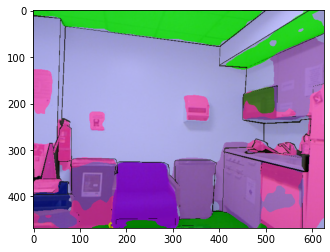

In [51]:
plt.imshow(pred_rgb)

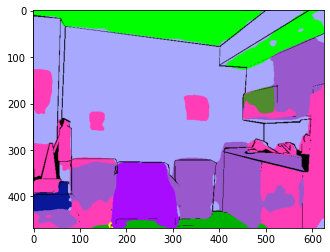

In [47]:
labels_np = labels.cpu().numpy()

pred_im_rgb = outputs.transpose(1,3) # NCHW => NWHC
pred_im_rgb = pred_im_rgb.transpose(1,2) # NWHC => NHWC
pred_im_rgb = pred_im_rgb.cpu().detach().numpy()
pred_im_rgb = np.argmax(pred_im_rgb,axis=-1)
pred_im_rgb[labels_np == 11] = 11

pred_im_rgb = class_colors[pred_im_rgb]

#pred_im_rgb = decode_outputs(inputs, outputs,labels)

plt.imshow(pred_im_rgb[0])

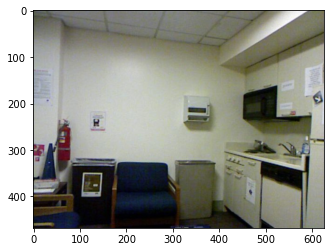

In [36]:
im_input=decode_input(inputs)
im_output=decode_outputs(inputs, outputs,labels)

plt.imshow(im_input[0])

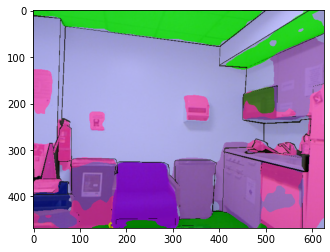

In [30]:
plt.imshow(im_output[0])